In [1]:
'Random forest emulation for the ∆LWP_conv*A_conv*Incoming_Solar vs ∂LWP/∂WCB cored by ∆CRE'

'Random forest emulation for the ∆LWP_conv*A_conv*Incoming_Solar vs ∂LWP/∂WCB cored by ∆CRE'

In [2]:
'''Started on 05/07/25
last edited on 05/07/25'''

'Started on 05/07/25\nlast edited on 05/07/25'

# imports

In [3]:
import gc
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [ ]:
gc.collect()

In [5]:
from load_xarray import *


In [6]:
from lat_weight_mean import *


In [7]:
from TOAf import *

# load data

In [9]:
LWP_varn="dLWPmap_gol"; T_varn="dTSmap_gol"; ocean=False
Lv = 2264705.  # J/kg
### Load maps
file_names = {
    "dLWPmap": LWP_varn,
    "dTSmap": T_varn,
    "pe_maps_ol": "pe_maps_ol",
    "pe_maps_o": "pe_maps_o"
}
datasets = {var_name: load_xarray(file_name) for var_name, file_name in file_names.items()}

### ∆LWP map
dLWP_TSmap = datasets['dLWPmap'] / datasets['dTSmap']  # kgm-2K-1
dLWP_TSmap = dLWP_TSmap.assign_coords(lon=(((dLWP_TSmap.lon + 180) % 360) - 180))
dLWP_TSmap = dLWP_TSmap.sortby('lon')

### cloud feedback
cf = (load_xarray('dSWCREmap')+load_xarray('dLWCREmap'))/datasets['dTSmap']
cf = cf.assign_coords(lon=(((cf.lon + 180) % 360) - 180))
cf = cf.sortby('lon')
cf_mean = lat_weight_mean(cf)[0]

### PD MC map
PDMC_QFLX_da = datasets['pe_maps_o' if ocean else 'pe_maps_ol']*86400

### converging area
convergence_mask = PDMC_QFLX_da > 0

### incoming solar flux  #downwelling SW flux at TOA
SW_d_list = []
run_numbers = []
for fnum in range(263):
    try:
        fnums = f"{fnum:03d}"
        SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
        SW_maps = np.mean(SWfn_list['data'], axis=0)
        # SW_mean = lat_weight_mean(SW_maps)
        SW_d_list.append(SW_maps)
        run_numbers.append(fnum)
    except FileNotFoundError:
        print(f'{fnums} not available.')
        continue
SW_d_list = np.array(SW_d_list)
SWD_da = xr.DataArray(data=SW_d_list,
                      coords={'runs': run_numbers,
                              'lat': SWfn_list['lat'],
                              'lon': SWfn_list['lon']},
                      dims=['runs','lat','lon'])
SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
SWD_da = SWD_da.sortby('lon')  # [Wm-2]
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
    land_mask_da = xr.DataArray(
        land_mask,
        coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
        dims=['lat', 'lon']
    )
    SWD_da = SWD_da * land_mask_da

### convergence contribution
# plt.figure(); dLWP_TSmap[0].plot()
# plt.figure(); SWD_da[0].plot()
# plt.figure(); PDMC_QFLX_da[0].plot()
conv_contrib = dLWP_TSmap*convergence_mask*SWD_da*PDMC_QFLX_da
# conv_contrib = convergence_mask*SWD_da*PDMC_QFLX_da
# plt.figure(); conv_contrib[0].plot()
conv_contrib_mean, conv_contrib_sem, conv_contrib_std = lat_weight_mean(conv_contrib)
filter_conv = lat_weight_mean(convergence_mask*SWD_da*PDMC_QFLX_da)[0]
# print(filter_conv)

### TOA means
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

### global precipitation efficiency means
file = np.load('/glade/campaign/uwyo/wyom0124/variables_filtered/pe.npz')
pe_gm_o = xr.DataArray(file['data'], dims=['runs'], coords={'runs': file['runs']})  # [s-1]

### Select only common runs for all datasets
final_data_n = {
    "xmap": pe_gm_o,
    "ymap": conv_contrib_mean,
    "clrmap": cf_mean,
    "filter": filtered_TOA_15,
    "filter2": filter_conv
}
keys = list(final_data_n.keys())
common_members = final_data_n[keys[0]]["runs"].values
for name in keys:
    print(name)
    common_members = np.intersect1d(common_members, final_data_n[name]["runs"].values)
final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

xmap
ymap
clrmap
filter
filter2


In [10]:
Lv = 2264705.  # J/kg

In [11]:
## Load MERRA observational data
### Moisture convergence
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
                            combine='by_coords', parallel=True)
monthly_merrafn = merrafn.mean(dim='time')
merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
merra_conv_area = xr.where(merraMC > 0, 1, 0)
merra_conv_sw = merra_conv_area*merraSW*merraMC
# plt.figure(); merra_conv_sw.plot()
merraMC_mean, merraMC_sem, _ = lat_weight_mean(merra_conv_sw)
print(merraMC_mean.values)
obs_constraint_lower = merraMC_mean.values - merraMC_sem.values
obs_constraint_upper = merraMC_mean.values + merraMC_sem.values

# Identify constrained points
PPE_conv_SWD = final_data['filter2']
constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)


287.99544532834324


In [12]:
## Constrained Pe
from cyclone_obs import *
from cyclone_metrics import *
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
obs_dict = cyclone_obs()
PPE_grad_LWP_WCB = PPE_grad_LWP_WCB.sel(runs=common_members)

In [13]:
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
wcb = obs_dict['sfcwind']*obs_dict['wvp']*2.66e-7*86400  #[m/s * kg/m2 * m.mm/kg * s/day = mm/day]
num_bins = 10
ind = ~np.isnan(wcb * cloudlwp)

# Calculate bins and statistics in one go
bin_stats = stats.binned_statistic(wcb[ind], [cloudlwp[ind], wcb[ind]], statistic='mean', bins=num_bins)
lwp_bin, wcb_bin = bin_stats.statistic
count = stats.binned_statistic(wcb[ind], wcb[ind], statistic='count', bins=num_bins).statistic
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(wcb_bin)*count)/np.nansum(count)

obs_grad_LWP_WCB = obs_grad.copy()

lower_bound_WCB = obs_grad_LWP_WCB - 0.1 * obs_grad_LWP_WCB
upper_bound_WCB = obs_grad_LWP_WCB + 0.1 * obs_grad_LWP_WCB

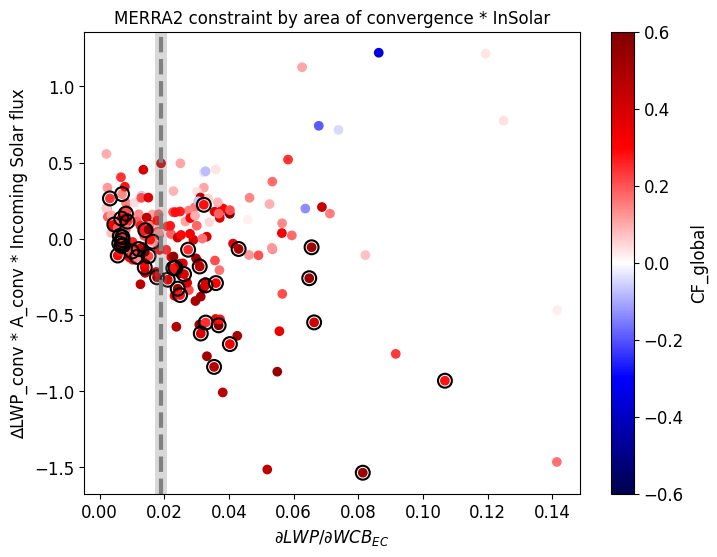

In [14]:
#### Pe - ∆LWP_conv*A_conv - total global CF
#### MERRA2 constraint by area of convergence * SWD
x_p = PPE_grad_LWP_WCB
y_p = final_data['ymap']
c_p = final_data['clrmap']
plt.scatter(x_p, y_p, c=c_p, cmap='seismic',
           vmin=-0.6, vmax=0.6)
plt.colorbar(label='CF_global')
plt.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
            edgecolor='black', facecolor='none', s=100, linewidth=1.5, label='Obs Constrained')
plt.axvline(x=obs_grad_LWP_WCB, color='grey', linestyle='--')
plt.axvspan(lower_bound_WCB, upper_bound_WCB, facecolor='grey', alpha=0.3)
plt.xlabel('$∂LWP/∂WCB_{EC}$')
plt.ylabel('∆LWP_conv * A_conv * Incoming Solar flux')
# plt.savefig('figures/∆LWP_Aconv_solarVS∂LWP∂WCBVSCF.png', bbox_inches='tight', dpi=500, facecolor='white')
plt.title('MERRA2 constraint by area of convergence * InSolar')
plt.show()

# RF emulator - simple

In [15]:
from sklearn.model_selection import train_test_split

In [18]:
ind = np.isnan(x_p*y_p*c_p)==False
X = np.column_stack((x_p.data[ind], y_p.data[ind]))  # shape (254, 2)
y = c_p.data[ind]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")


Test MSE: 0.0193
Test R² Score: 0.2450


# RF emulator (full dataset) - Barnes

In [22]:
'''https://github.com/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_ozone_joshuatree.ipynb'''

'https://github.com/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_ozone_joshuatree.ipynb'

In [23]:

import sys
import numpy as np
import seaborn as sb

import pandas as pd
import datetime
import tensorflow as tf
#import tensorflow.keras as keras
import sklearn
#import pydot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

2025-05-07 11:49:45.895676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/24.12/spack/opt/spack/openmpi/5.0.6/oneapi/2024.2.1/ptm3/lib:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/nvvm/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/extras/CUPTI/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/cuda/12.3.2/gcc/12.4.0/jw45/extras/Debugger/lib64:/glade/u/apps/casper/24.12/spack/opt/spack/intel-oneapi-compilers/2024.2.1/gcc/12.4.0/iq3b/compiler/2024.2/opt/compiler/lib:/glade/u/apps/casper/24.12/spack/opt/spack/intel-oneapi-compilers/2024.2.1/gcc/12.4.0/iq3b/compiler/2024.2/lib:/glade/u/apps/casper/24.12/spack/opt/spack/gcc/12.4.0/5b5c/lib64:/glade/u/apps/casper/24.12/s

In [24]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp.csv"
data = pd.read_csv(url,parse_dates=["DATE_TIME"],infer_datetime_format=True)

# Fix data issue with Daylight Savings Time
duplicate_dates = data['DATE_TIME'][data.duplicated('DATE_TIME')]
for dup_date in duplicate_dates:
  idx = data['DATE_TIME'].eq(dup_date).idxmax()
  data.at[idx, 'DATE_TIME'] = dup_date - pd.Timedelta(value=1, unit='hours')

# Add hour and day of year
data['HOUR'] = data['DATE_TIME'].dt.hour
data['MONTH'] = data['DATE_TIME'].dt.month
data['YEAR'] = data['DATE_TIME'].dt.year
data['DAYOFYEAR'] = data['DATE_TIME'].dt.dayofyear
data.sort_values('DATE_TIME', inplace=True, ignore_index = True)

In [25]:


# MODIFY: input variables
# DO NOT USE: "OZONE" or "TEMPERATURE_DELTA"
INPUT_VARIABLES = [
    "TEMPERATURE",
    "RELATIVE_HUMIDITY",
    "WINDSPEED",
]

In [26]:


# Let's isolate our variables of interest and take the 8-hour running mean

# First using input and output variables together to take running mean
df_data_to_be_used = data[['OZONE'] + INPUT_VARIABLES]

# Here we take the 8-hour rolling mean (note: DATE_TIME does not work)
df_data_to_be_used = df_data_to_be_used.rolling(8).mean()

# Now adding Date and Time components
df_data_to_be_used[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']] = \
    data[['DATE_TIME', 'HOUR', 'MONTH', 'YEAR']]

# Dropping NaNs
df_data_to_be_used.dropna(inplace=True)

display(df_data_to_be_used.head())

,OZONE,TEMPERATURE,RELATIVE_HUMIDITY,WINDSPEED,DATE_TIME,HOUR,MONTH,YEAR
7,45.125,3.299987,30.875,3.337462,2010-01-01 07:00:00,7,1,2010
8,45.125,3.749988,30.875,2.899962,2010-01-01 08:00:00,8,1,2010
9,45.375,4.374975,30.500,2.649962,2010-01-01 09:00:00,9,1,2010
10,45.625,5.074975,30.375,2.387462,2010-01-01 10:00:00,10,1,2010
11,46.000,5.862475,29.875,2.249975,2010-01-01 11:00:00,11,1,2010


In [27]:


# Creating a numpy array for our inputs and outputs
input = df_data_to_be_used[INPUT_VARIABLES].values
output_raw = df_data_to_be_used['OZONE'].values

# Creating numpy arrays for time/date info for visualizations
hour = df_data_to_be_used['HOUR'].values
month = df_data_to_be_used['MONTH'].values
year = df_data_to_be_used['YEAR'].values

# Turning ozone into classification problem:
  # Class 0: Good, Class 1: Fair, Class 2: Poor
output_class = (output_raw >= 55).astype(int) + (output_raw >= 71).astype(int)
output = (output_class.reshape(-1,1) == np.unique(output_class)).astype(int)

# Here is how our data is encoded into classes.
print('Ozone Value:', output_raw[0])
print('Ozone Class:', output_class[0])
print('Encoded As:', output[0])
print()
print('Ozone Value:', output_raw[2000])
print('Ozone Class:', output_class[2000])
print('Encoded As:', output[2000])

Ozone Value: 45.125
Ozone Class: 0
Encoded As: [1 0 0]

Ozone Value: 58.0
Ozone Class: 1
Encoded As: [0 1 0]


In [33]:
np.shape(input)

(199, 2)

In [34]:
np.shape(output)

(199,)

In [32]:
# Creating a numpy array for inputs and outputs
ind = np.isnan(x_p*y_p*c_p)==False
input = np.column_stack((x_p.data[ind], y_p.data[ind]))  # shape (254, 2)
output = c_p.data[ind]


In [37]:
# Splitting into training, testing, validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: Train-test split (e.g., 80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

# Step 2: Split train_val into train and validation (e.g., 75% of 80% = 60% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# building the model

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [44]:
### Here is where we actually build the model

# Create and Train the Random Forest Classifier
#-------------------------------------------------------------------------------------------------
# MODIFY: important tunable parameters (hyperparameters) for model
number_of_trees = 1               # number of trees to "average" together to create a random forest
tree_depth = 1                     # maximum depth allowed for each tree
node_split = 30                     # minimum number of training samples needed to split a node
leaf_samples = 30                   # minimum number of training samples required to make a leaf node
criterion = 'gini'                 # 'gini' or 'entropy'
bootstrap = False                  # whether to perform "bagging=bootstrap aggregating" or not
max_samples = None                 # number of samples to grab when training each tree IF bootstrap=True, otherwise None
class_weight = None                # class weights, default None. Use 'balanced' to weight by class frequency, or customize with format [{0:1.0,1:1.0}, {0:1.0,1:1.0}, {0:1.0,1:1.0}]
RAND_STATE = 13                    # specify random state for reproducibility
#-------------------------------------------------------------------------------------------------


In [45]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=number_of_trees,
    max_depth=tree_depth,
    min_samples_split=node_split,
    min_samples_leaf=leaf_samples,
    bootstrap=bootstrap,
    max_samples=max_samples,
    random_state=RAND_STATE
)

# Train the model
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=False, max_depth=1, min_samples_leaf=30,
                      min_samples_split=30, n_estimators=1, random_state=13)